请你添加一个for循环，分别训练7天的增长率density_growth模型，包括今天到明天（T+1）的增长率、今天到后天（T+2）的增长率、今天到大后天（T+3）的增长率、...、今天到（T+7）的增长率。

这样，在predict的时候，就能同时预测7天的增长率density_growth，包括今天到明天（T+1）的增长率、今天到后天（T+2）的增长率、今天到大后天（T+3）的增长率、...、今天到（T+7）的增长率。

然后就能基于今天的density，乘上增长率density_growth，得到未来的连续7天的density。具体而言，明天的density是基于今天，后天的density也是基于今天，大后天的density也是基于今天，以此类推。

对于最终得到的这些未来的连续7天的density，我们还可以分别计算RSME。一般来讲明天（T+1）的density的RSME会更准确，而（T+7）的density的RSME误差较大。

需要你注意：
- 训练的时候需要调用create_sequence_for_date，构建高维的train_sequences.append(seq)，seq包含了60天的数据
- 预测的时候，每一个step，也就是每进入新的一天：都需要加入今天的数据，弹出60天以前的数据。


训练 T+1 天的模型


/tmp/ipykernel_19632/2596879050.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_train = torch.FloatTensor(train_sequences)


Epoch [50/300], Loss: 0.0068
Epoch [100/300], Loss: 0.0008
Epoch [150/300], Loss: 0.0002
Epoch [200/300], Loss: 0.0003
Epoch [250/300], Loss: 0.0001
Epoch [300/300], Loss: 0.0002

训练 T+2 天的模型
Epoch [50/300], Loss: 0.0008
Epoch [100/300], Loss: 0.0007
Epoch [150/300], Loss: 0.0009
Epoch [200/300], Loss: 0.0002
Epoch [250/300], Loss: 0.0002
Epoch [300/300], Loss: 0.0003

训练 T+3 天的模型
Epoch [50/300], Loss: 0.0020
Epoch [100/300], Loss: 0.0002
Epoch [150/300], Loss: 0.0003
Epoch [200/300], Loss: 0.0003
Epoch [250/300], Loss: 0.0001
Epoch [300/300], Loss: 0.0002

训练 T+4 天的模型
Epoch [50/300], Loss: 0.0007
Epoch [100/300], Loss: 0.0022
Epoch [150/300], Loss: 0.0005
Epoch [200/300], Loss: 0.0002
Epoch [250/300], Loss: 0.0004
Epoch [300/300], Loss: 0.0001

训练 T+5 天的模型
Epoch [50/300], Loss: 0.0005
Epoch [100/300], Loss: 0.0022
Epoch [150/300], Loss: 0.0003
Epoch [200/300], Loss: 0.0001
Epoch [250/300], Loss: 0.0001
Epoch [300/300], Loss: 0.0001

训练 T+6 天的模型
Epoch [50/300], Loss: 0.0027
Epoch [100/

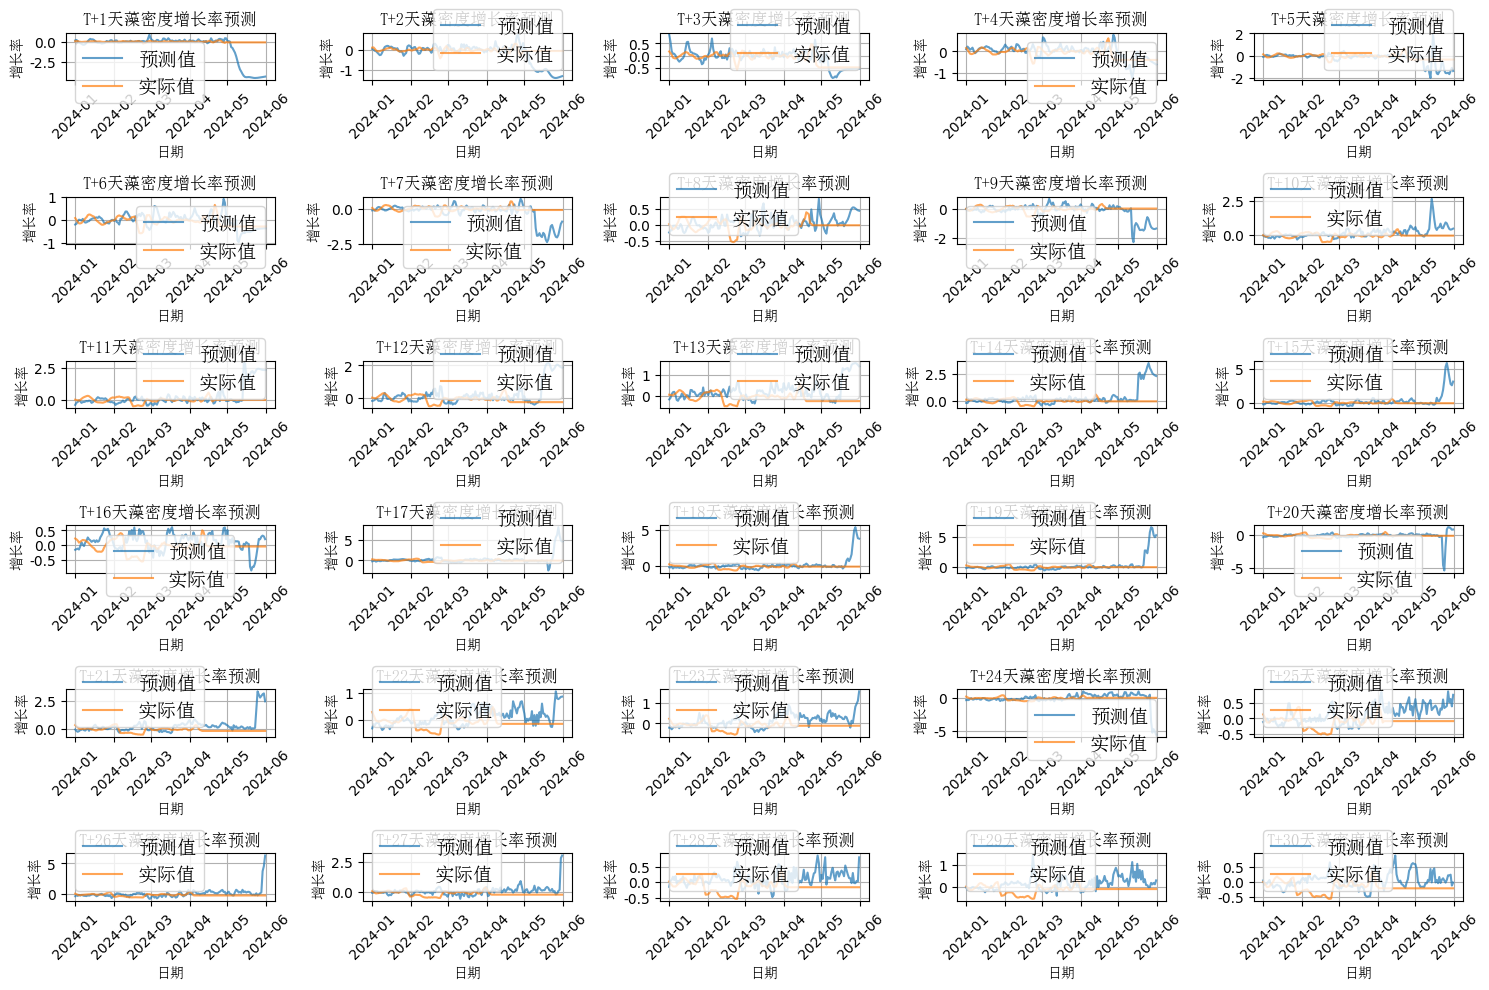

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from torch.optim.lr_scheduler import OneCycleLR

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')





# 读取数据
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算T+1到T+30的增长率
for days in range(1, 31):
    df[f'density_growth_{days}d'] = (df['density'].shift(-days) - df['density']) / df['density']
    df[f'density_growth_{days}d'] = df[f'density_growth_{days}d'].interpolate(method='linear')
    window_size = 3
    df[f'density_growth_{days}d_smoothed'] = df[f'density_growth_{days}d'].rolling(window=window_size, center=True).mean()
    df[f'density_growth_{days}d_smoothed'] = df[f'density_growth_{days}d_smoothed'].interpolate(method='linear')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

def create_sequence_for_date(data, date_index, seq_length):
    """为指定日期创建输入序列"""
    if date_index < seq_length:
        return None
    return data[date_index - seq_length:date_index]

# 基础特征
base_features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                'turbidity', 'chla', 'density', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                'strong_wind']

# 为每个预测天数创建一个模型和数据集
models = {}
predictions_all = {}
actual_values_all = {}

for days in range(1, 31):
    print(f"\n训练 T+{days} 天的模型")
    
    # 添加对应天数的增长率特征
    features = base_features + [f'density_growth_{days}d', f'density_growth_{days}d_smoothed']
    
    data = df[features].values
    data = np.nan_to_num(data, nan=0)
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # 划分训练集和测试集
    train_size = int(len(df) * 0.8)
    train_dates = df.index[:train_size]
    test_dates = df.index[train_size:]
    test_data = scaled_data[train_size:]
    
    seq_length = 60
    
    # 构建训练序列
    train_sequences = []
    train_targets = []
    for i in range(seq_length, train_size):
        seq = create_sequence_for_date(scaled_data, i, seq_length)
        if seq is not None:
            train_sequences.append(seq)
            train_targets.append(scaled_data[i, features.index(f'density_growth_{days}d_smoothed')])
    
    X_train = torch.FloatTensor(train_sequences)
    y_train = torch.FloatTensor(train_targets)
    
    train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # 初始化和训练模型
    model = LSTMModel(input_size=len(features), hidden_size=64, num_layers=2, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 300
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    models[days] = (model, scaler, features)
    
    # 预测阶段
    model.eval()
    predictions = []
    actual_values = []
    current_sequence = scaled_data[train_size-seq_length:train_size]
    
    with torch.no_grad():
        for i in range(len(test_data)-days):
            current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
            pred = model(current_sequence_tensor)
            
            predictions.append(pred.item())
            actual_values.append(test_data[i+days, features.index(f'density_growth_{days}d_smoothed')])
            
            current_sequence = np.vstack([
                current_sequence[1:],
                test_data[i]
            ])
    
    # 反归一化预测结果
    pred_full_features = np.zeros((len(predictions), len(features)))
    actual_full_features = np.zeros((len(actual_values), len(features)))
    
    growth_idx = features.index(f'density_growth_{days}d_smoothed')
    pred_full_features[:, growth_idx] = np.array(predictions)
    actual_full_features[:, growth_idx] = np.array(actual_values)
    
    predictions_all[days] = scaler.inverse_transform(pred_full_features)[:, growth_idx]
    actual_values_all[days] = scaler.inverse_transform(actual_full_features)[:, growth_idx]

# 计算每个预测天数的RMSE
for days in range(1, 31):
    rmse = np.sqrt(mean_squared_error(actual_values_all[days], predictions_all[days]))
    print(f"T+{days}天预测的RMSE: {rmse:.4f}")

# 绘制2024年1-5月的预测结果
plt.figure(figsize=(15, 10))
start_date = '2024-01-01'
end_date = '2024-05-31'

# 确保预测日期和预测值长度一致
prediction_dates = test_dates[:-30]  # 调整日期范围以适应最长的预测期
predictions_length = len(predictions_all[1])  # 使用第一天预测作为参考长度
prediction_dates = prediction_dates[-predictions_length:]  # 截取对应长度的日期

mask = (pd.to_datetime(prediction_dates) >= start_date) & (pd.to_datetime(prediction_dates) <= end_date)

for days in range(1, 31):
    plt.subplot(6, 5, days)
    plt.plot(pd.to_datetime(prediction_dates)[mask], predictions_all[days][-len(prediction_dates):][mask], 
             label='预测值', alpha=0.7)
    plt.plot(pd.to_datetime(prediction_dates)[mask], actual_values_all[days][-len(prediction_dates):][mask], 
             label='实际值', alpha=0.7)
    
    plt.title(f'T+{days}天藻密度增长率预测', fontproperties=chinese_font, fontsize=12)
    plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
    plt.ylabel('增长率', fontproperties=chinese_font, fontsize=10)
    plt.legend(prop=chinese_font)
    plt.grid(True)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()


In [2]:
# 计算每个预测天数的增长率RMSE
print("增长率预测的RMSE:")
for days in range(1, 31):  # 改为1-30天
    rmse = np.sqrt(mean_squared_error(actual_values_all[days], predictions_all[days]))
    print(f"T+{days}天预测的RMSE: {rmse:.4f}")

# 基于增长率计算2024年每一天未来30天的藻密度
density_predictions = {}  # 存储每一天的未来30天预测密度
density_actuals = {}     # 存储每一天的未来30天实际密度

# 获取密度特征的索引
density_idx = base_features.index('density')

# 获取2024年的日期范围
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-31')

# 对2024年的每一天进行预测
for current_date in dates_2024:
    # 找到当前日期在测试集中的索引
    date_idx = np.where(pd.to_datetime(test_dates) == current_date)[0]
    
    if len(date_idx) > 0:
        idx = date_idx[0]
        # 确保索引不超出范围
        if idx < len(test_data) and idx < len(predictions_all[1]) - 30:  # 减去30确保有足够的预测数据
            current_density = test_data[idx][density_idx]  # 获取当前日期的藻密度
            
            # 初始化当前日期的预测和实际值字典
            if current_date not in density_predictions:
                density_predictions[current_date] = {}
                density_actuals[current_date] = {}
            
            # 计算未来30天的藻密度，都是基于当前日期的密度
            for days in range(1, 31):  # 改为1-30天
                # 直接用当天的密度乘以对应天数的增长率
                if idx + days <= len(predictions_all[days]):  # 确保索引在有效范围内
                    density_predictions[current_date][days] = current_density * (1 + predictions_all[days][idx])
                    density_actuals[current_date][days] = current_density * (1 + actual_values_all[days][idx])


增长率预测的RMSE:
T+1天预测的RMSE: 1.7954
T+2天预测的RMSE: 0.5612
T+3天预测的RMSE: 0.2220
T+4天预测的RMSE: 0.2674
T+5天预测的RMSE: 0.5686
T+6天预测的RMSE: 0.2773
T+7天预测的RMSE: 0.7036
T+8天预测的RMSE: 0.3122
T+9天预测的RMSE: 0.6168
T+10天预测的RMSE: 0.4553
T+11天预测的RMSE: 1.0379
T+12天预测的RMSE: 0.9908
T+13天预测的RMSE: 0.7622
T+14天预测的RMSE: 1.1412
T+15天预测的RMSE: 1.6868
T+16天预测的RMSE: 0.3531
T+17天预测的RMSE: 1.6988
T+18天预测的RMSE: 1.4924
T+19天预测的RMSE: 2.2955
T+20天预测的RMSE: 0.8232
T+21天预测的RMSE: 1.2509
T+22天预测的RMSE: 0.5108
T+23天预测的RMSE: 0.5093
T+24天预测的RMSE: 2.2694
T+25天预测的RMSE: 1.5007
T+26天预测的RMSE: 3.2054
T+27天预测的RMSE: 1.7946
T+28天预测的RMSE: 2.3066
T+29天预测的RMSE: 4.2506
T+30天预测的RMSE: 2.3213



2024年藻密度预测的RMSE:
T+1天预测的RMSE: 0.0073
T+2天预测的RMSE: 0.0077
T+3天预测的RMSE: 0.0111
T+4天预测的RMSE: 0.0122
T+5天预测的RMSE: 0.0125
T+6天预测的RMSE: 0.0142
T+7天预测的RMSE: 0.0135
T+8天预测的RMSE: 0.0133
T+9天预测的RMSE: 0.0138
T+10天预测的RMSE: 0.0126
T+11天预测的RMSE: 0.0148
T+12天预测的RMSE: 0.0168
T+13天预测的RMSE: 0.0167
T+14天预测的RMSE: 0.0164
T+15天预测的RMSE: 0.0176
T+16天预测的RMSE: 0.0189
T+17天预测的RMSE: 0.0197
T+18天预测的RMSE: 0.0165
T+19天预测的RMSE: 0.0152
T+20天预测的RMSE: 0.0155
T+21天预测的RMSE: 0.0176
T+22天预测的RMSE: 0.0160
T+23天预测的RMSE: 0.0169
T+24天预测的RMSE: 0.0185
T+25天预测的RMSE: 0.0176
T+26天预测的RMSE: 0.0192
T+27天预测的RMSE: 0.0172
T+28天预测的RMSE: 0.0189
T+29天预测的RMSE: 0.0231
T+30天预测的RMSE: 0.0205


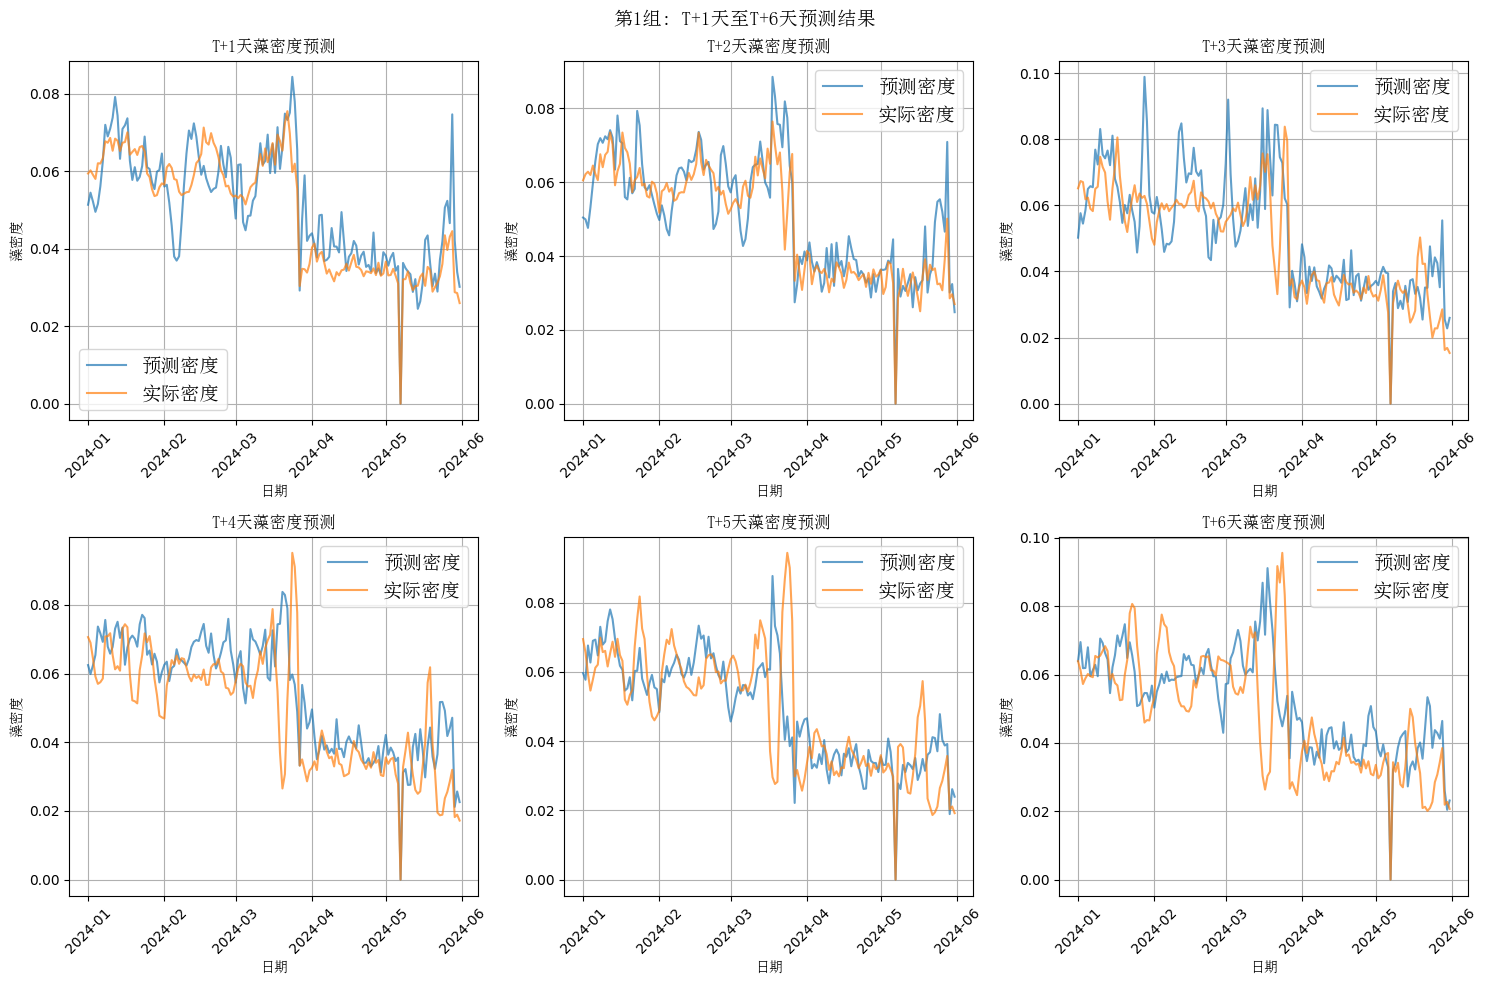

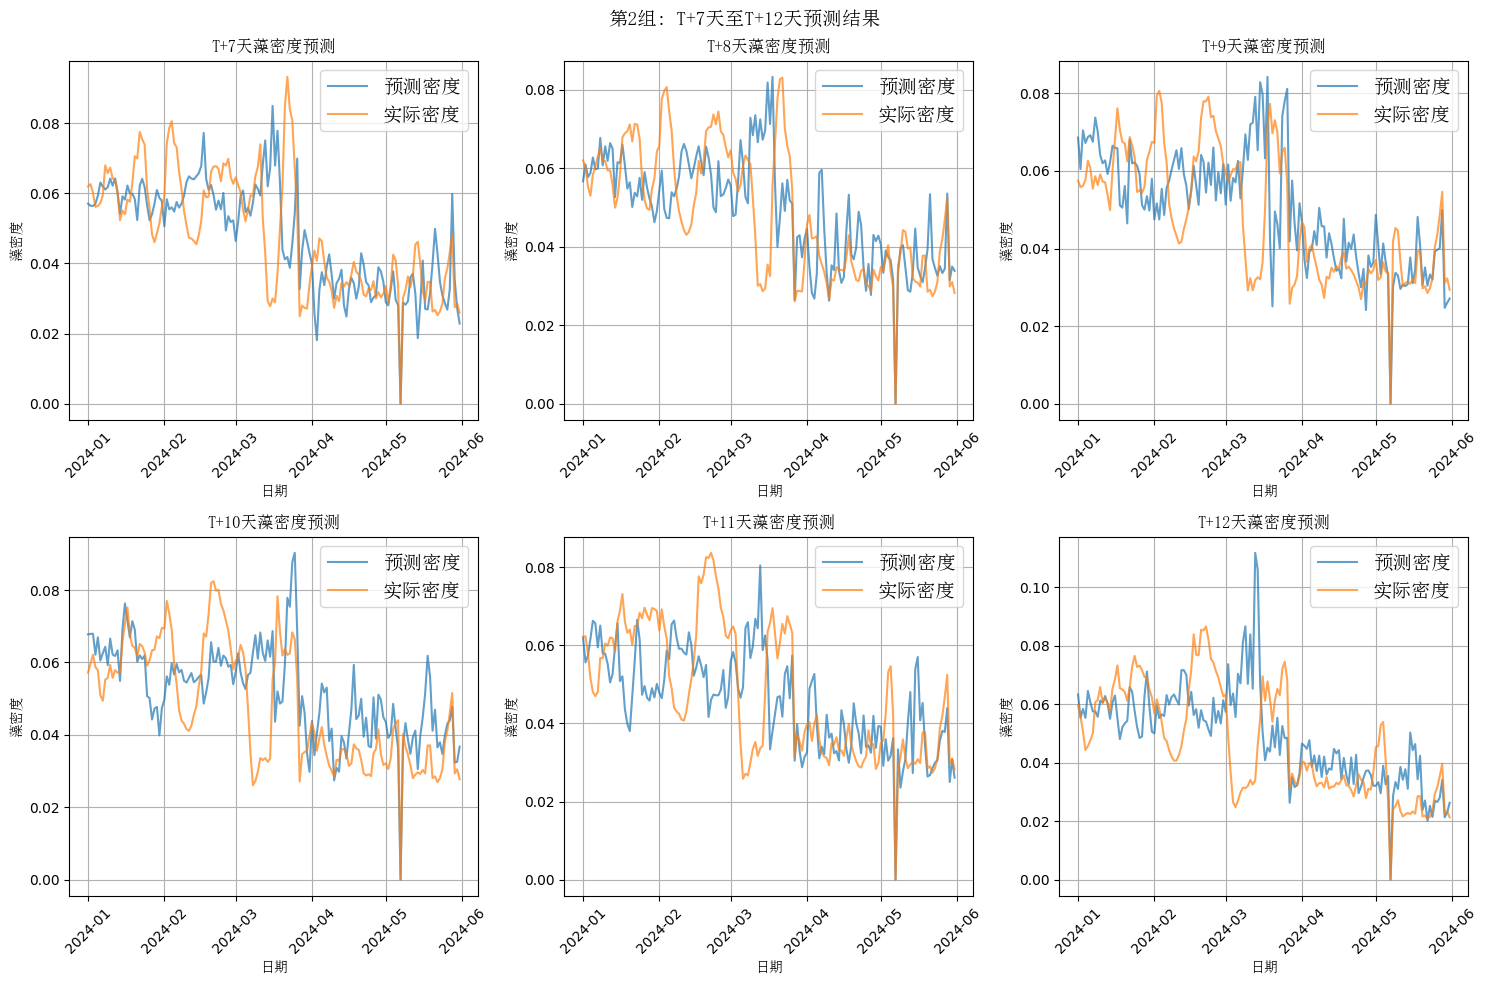

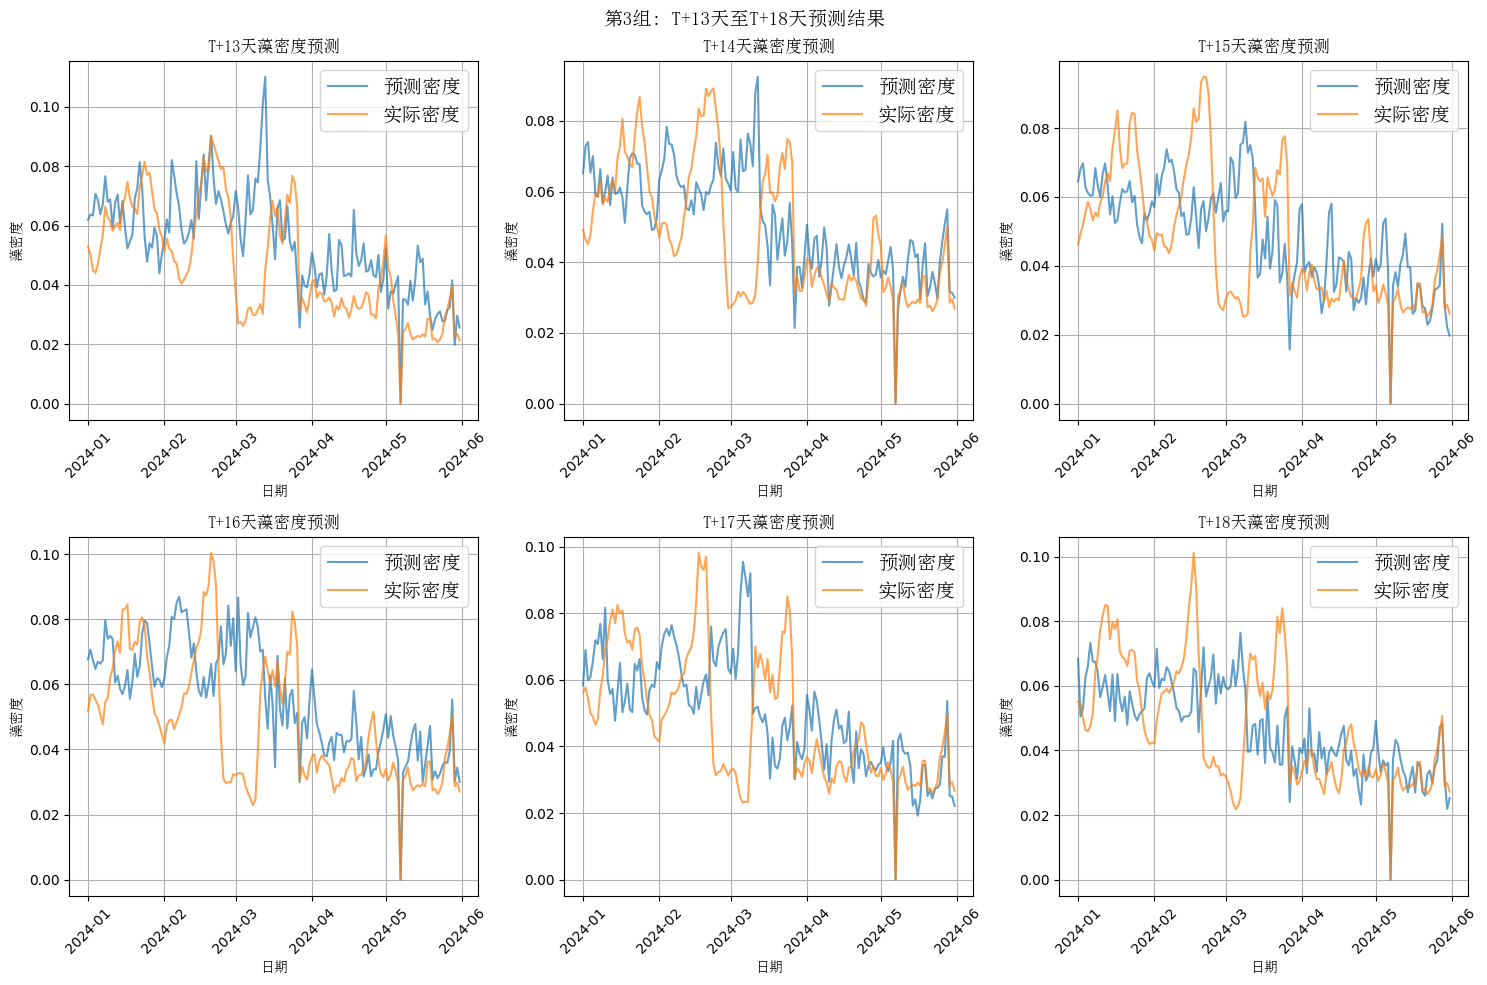

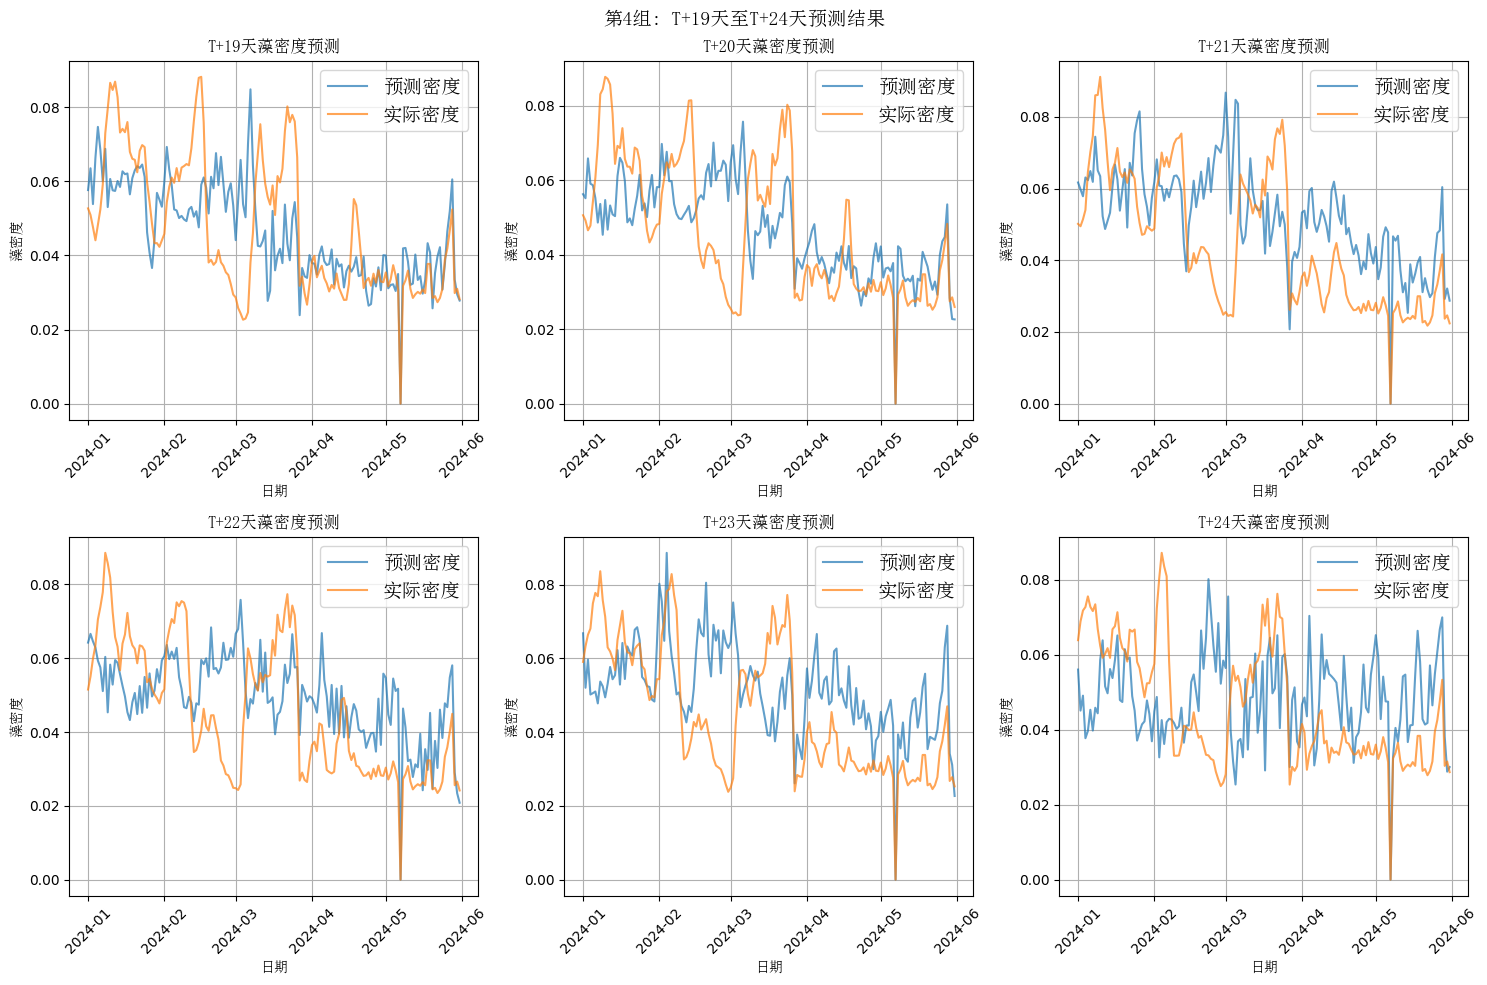

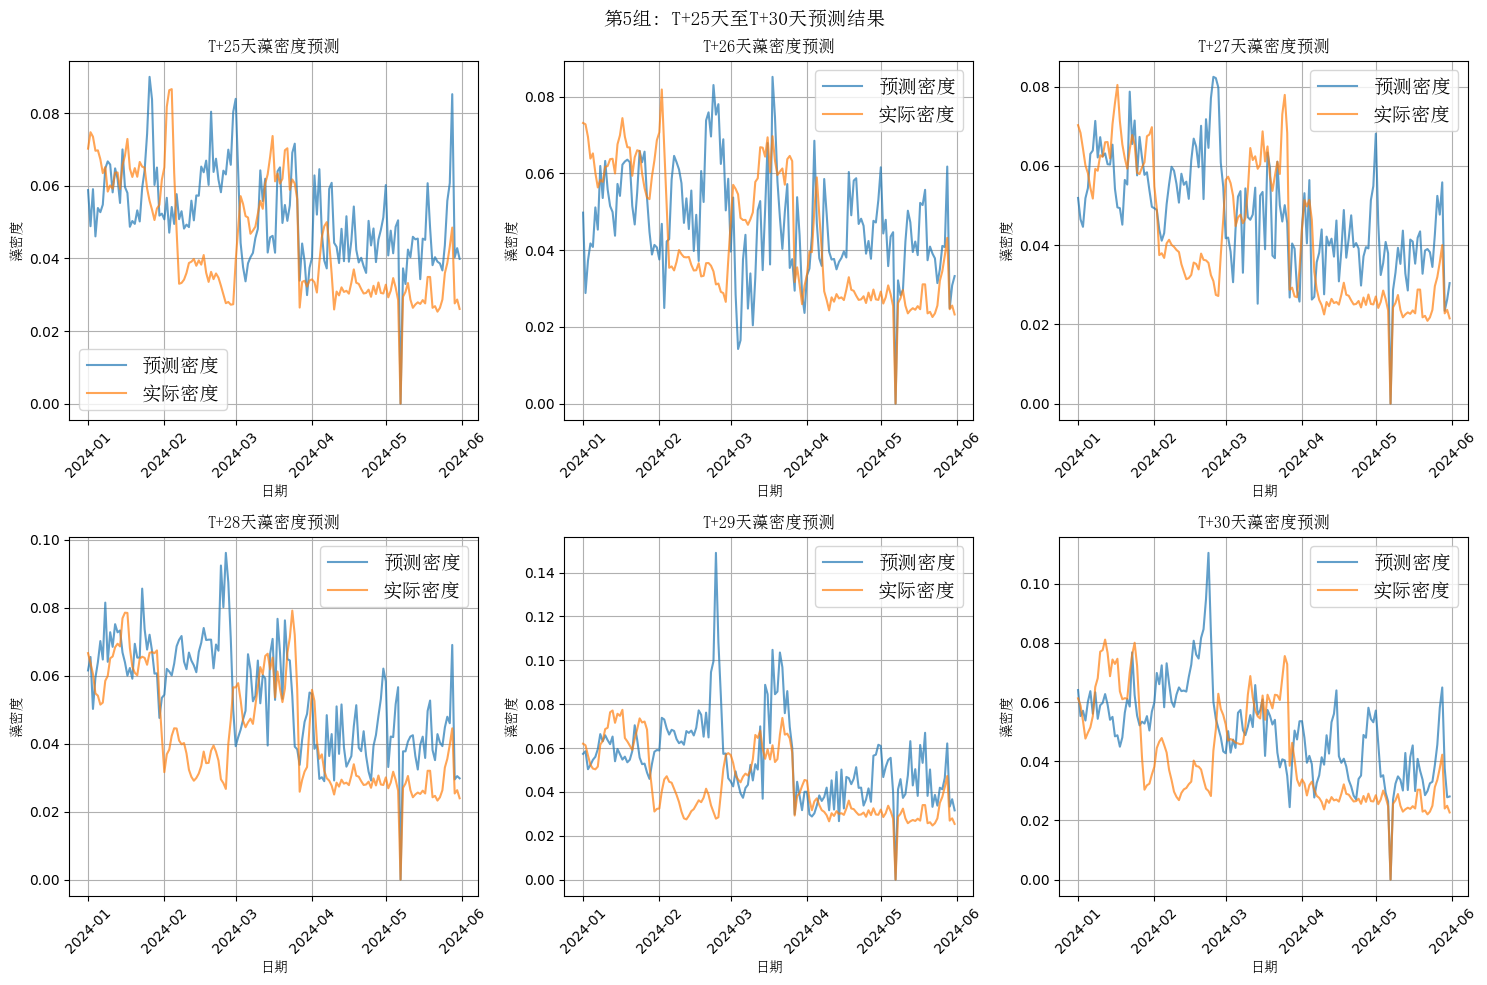

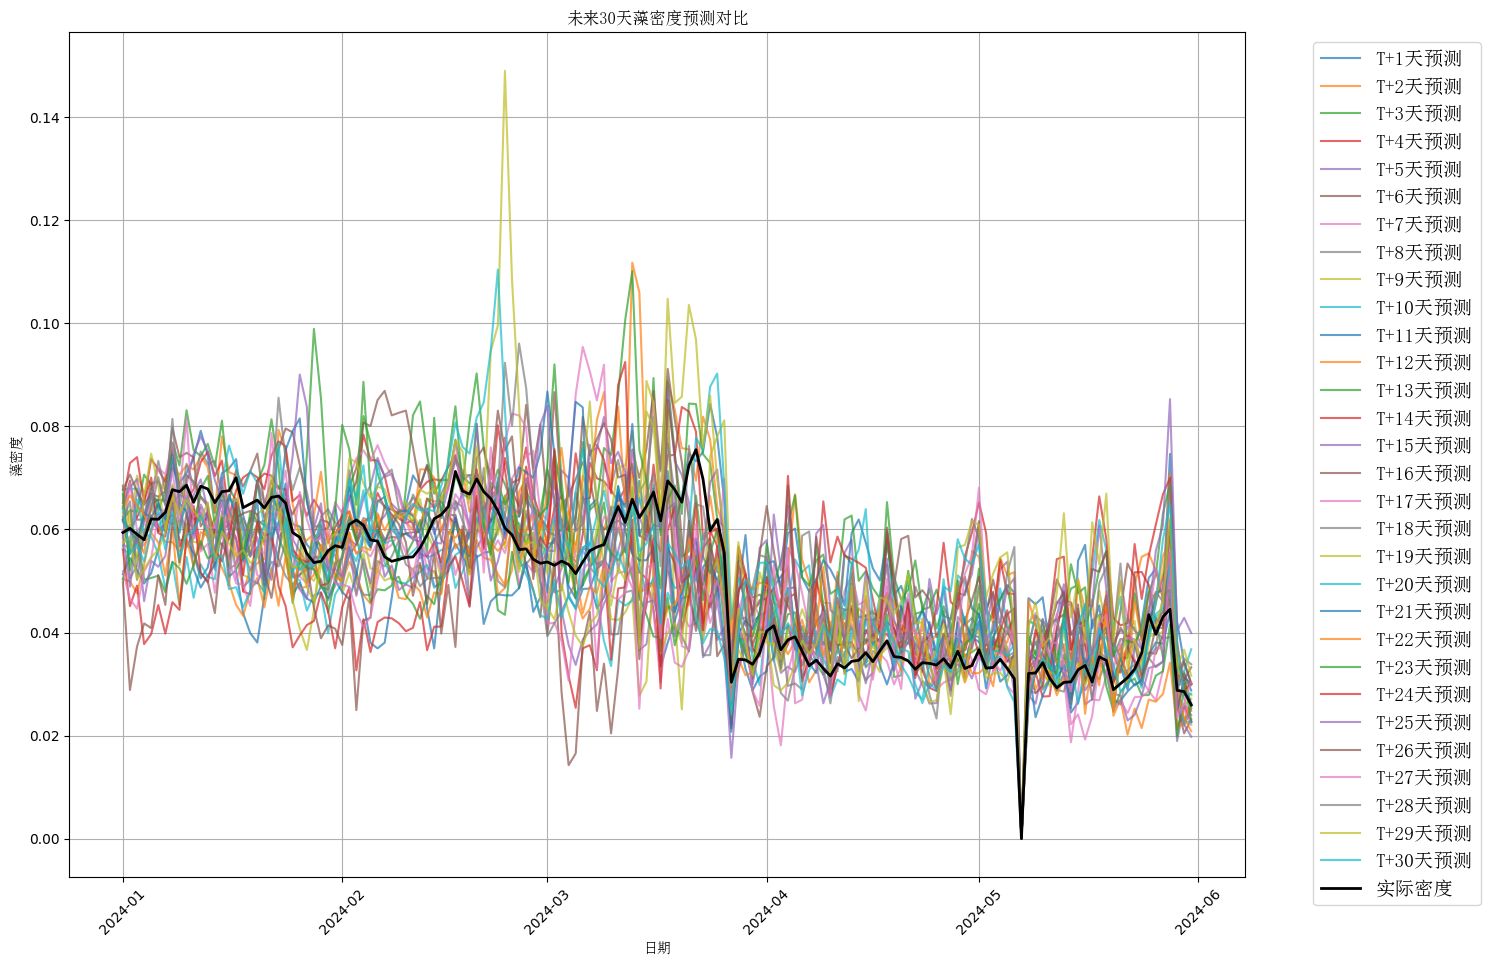

In [5]:
# 计算每个预测天数的RMSE
print("\n2024年藻密度预测的RMSE:")
for days in range(1, 31):  # 改为1-30天
    # 收集所有日期的预测值和实际值
    predictions = []
    actuals = []
    for date in density_predictions.keys():
        if days in density_predictions[date]:
            predictions.append(density_predictions[date][days])
            actuals.append(density_actuals[date][days])
    
    if predictions and actuals:
        density_rmse = np.sqrt(mean_squared_error(actuals, predictions))
        print(f"T+{days}天预测的RMSE: {density_rmse:.4f}")

# 绘制2024年1-5月的预测结果
start_date = '2024-01-01'
end_date = '2024-05-31'

# 获取2024年的预测日期
prediction_dates = []
predictions = []
actuals = []

for date in density_predictions.keys():
    if pd.to_datetime(start_date) <= date <= pd.to_datetime(end_date):
        prediction_dates.append(date)
        for days in range(1, 31):  # 改为1-30天
            if days == 1:
                predictions.append(density_predictions[date][days])
                actuals.append(density_actuals[date][days])

# 每6天绘制一张图，共5张图
for group in range(5):  # 0-4共5组
    plt.figure(figsize=(15, 10))
    for i in range(6):  # 每组6天
        days = group * 6 + i + 1
        if days <= 30:  # 确保不超过30天
            plt.subplot(2, 3, i+1)
            plt.plot(prediction_dates, [density_predictions[date][days] for date in prediction_dates], 
                     label='预测密度', alpha=0.7)
            plt.plot(prediction_dates, [density_actuals[date][days] for date in prediction_dates],
                     label='实际密度', alpha=0.7)
            
            plt.title(f'T+{days}天藻密度预测', fontproperties=chinese_font, fontsize=12)
            plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
            plt.ylabel('藻密度', fontproperties=chinese_font, fontsize=10)
            plt.legend(prop=chinese_font)
            plt.grid(True)
            plt.xticks(rotation=45)
    
    plt.suptitle(f'第{group+1}组: T+{group*6+1}天至T+{min((group+1)*6, 30)}天预测结果', 
                 fontproperties=chinese_font, fontsize=14)
    plt.tight_layout()
    plt.show()

# 单独绘制所有天数的藻密度预测结果对比
plt.figure(figsize=(15, 10))
for days in range(1, 31):  # 改为1-30天
    plt.plot(prediction_dates, [density_predictions[date][days] for date in prediction_dates],
             label=f'T+{days}天预测', alpha=0.7)
plt.plot(prediction_dates, [density_actuals[date][1] for date in prediction_dates],
         label='实际密度', color='black', linewidth=2)

plt.title('未来30天藻密度预测对比', fontproperties=chinese_font, fontsize=12)
plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
plt.ylabel('藻密度', fontproperties=chinese_font, fontsize=10)
plt.legend(prop=chinese_font, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
